In [28]:
import pandas as pd
import numpy as np


## 3D Mechanism
The 3D-Laplace mechanism uses three variates:
1. Gamma distribution with formula $D_\epsilon, R(r) = \frac{1}{2}\epsilon^3r^2 exp^{-\epsilon r}$
2. $D{\epsilon},\Theta(\theta) = \frac{1}{\pi}$
3. $D{\epsilon},\Psi(\psi) = \frac{1}{2\pi}$

Both $\theta$ and $\psi$ are generated based on a unit sphere (sphere [1,1]).
Ergo, 2 and 3 are a vector $U = (\theta, \psi)$ and are scaled according to 1. So, when we have a random point $x_0 \in R^3$, the noise is added using $x_0 + Ur$
This is in line with the spherical coordinate system:

 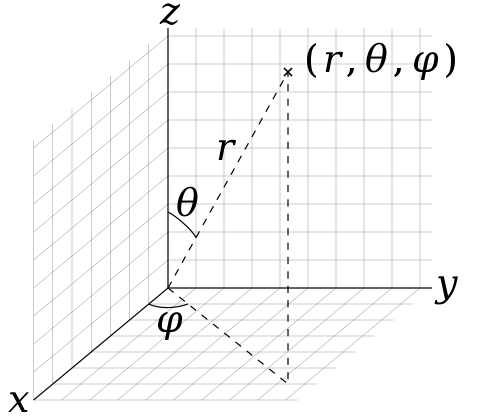
 


Steps to convert to nD-Laplace would then be:
- Instead of a unit sphere, we need to generate a unit hypersphere
- Modify the gaussian scaling

One of the difficulties for this is, we can't visualize it.


## nD-Laplace research
A hypersphere is conventionally defined as: $x1^2+x^2+x3^3+...+xd^2 < R^2$.
We are be-able to generate a unit hypersphere using this formula, where each point $x \in R^n$ is a unfiormly distributed random variable between $[-1,1]$. 
The PDF of the uniform distribution is $f(x) = \frac{1}{b-a}$, where $a$ and $b$ are the lower and upper bounds of the distribution.




In [29]:
np.random.uniform()

0.3032146146909942

In [30]:
def generate_unit_hypersphere(dimensions):
    x = np.random.uniform(0, 1, dimensions)
    sphere = 0
    for j in range(dimensions):
        sphere += x[j] ** 2
    return sphere

In [31]:
generate_unit_hypersphere(9)


1.9015279445976419

Now we whould sample random polar angle $\theta$ and azimuthal angle $\psi$ from the uniform hypersphere.

In [32]:
#muller-marsaglia method
import math
import random


def spherepicking(n):
    while True:           #to get rid off [0,0,0,0] case
        l = [random.gauss(0, 1) for i in range(n)]
        sumsq = sum([x * x for x in l])
        if sumsq > 0:
            break
    norm = 1.0 / math.sqrt(sumsq)
    pt = [x * norm for x in l]
    return pt

spherepicking(9)

[-0.6786292834684036,
 0.07380388134574097,
 0.3206547331754146,
 -0.14845264355483873,
 -0.4050713418606992,
 -0.3340150367746253,
 0.35932248645394793,
 0.0023705202347725973,
 0.06626108967739501]

The paper propsed here implemented it similarly: https://arxiv.org/pdf/1811.10256.pdf. 

So instead of calculating z as $\theta$ and $\psi$, we need to calculate it as a random variable selected from a uniform n-sphere.
This can be done according to the formula formulated by georgemarsagliaChoosingPointSurface1972.
The amount of dimensions, are the scale of the gamma distribution (georgemarsagliaChoosingPointSurface1972, 3D-geoindstinguishability)


In [69]:
from scipy.stats import gamma

def generate_nd_laplace_noise(x, epsilon):
    n = len(x)
    sphere_noise = spherepicking(n)
    z = []
    for i in range(n):
        u = sphere_noise[i]
        r = gamma.rvs(n, scale=1/epsilon)
        z.append(x[i] + (r * u))
    return z


In [70]:
x = np.random.uniform(0, 5, 5)
x

array([1.89691835, 1.71917605, 4.87676424, 0.96901627, 0.43428875])

In [117]:
generate_nd_laplace_noise(x, 9)

[2.7272876096599177,
 1.6462965261049043,
 6.053629562114703,
 1.1564351448571903,
 1.7970918965272935]